In [74]:
import os
import decouple
config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
import sys
sys.path.insert(0, '')

from loaders.local import DataHandler as dh
from preprocessing.feature_builders import PredictorFeaturesBuilder as pfb

import pandas as pd
import numpy as np
from scipy.stats import norm, gamma

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

# Feature Building

In this notebook we'll prepare the dataset for modelling. The features that we're going to build fall into 3 categories:

1. Venue features for each runner (these are known at the start of the race and are the same for each runner)

index: RaceDate, FasttrackRaceId
- Race distance (normalised)
- Race grade
- Track condition (data unavailable?)
2. Static runner features (these are known at the start of the race)

index: RaceDate, FasttrackRaceId, FasttrackDogId
- Weight
- Box number
- Whether adjacent boxes are empty
3. Inferred runner features (these are computed after the race then estimated for the upcoming race using time series methods on that dog's previous races)
- Average Speed
- Boolean "is winner?"
- Win probability (or StartPrice)
- "PIR"
- "Checks"
4. Trainer features (will be important for new runners)
- ...

Note:
- Throughout the notebook "dog" and "runner" are used interchangeably

In [11]:
data = dh.get_train_data()
data = data.set_index(['RaceDate', 'FasttrackRaceId', 'FasttrackDogId', 'TrainerId'])
data

Place          DogName  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                           
2018-07-01 335811282       157500927      7683           1      RAINE ALLEN   
                           1820620018     137227         2       SURF A LOT   
                           1950680026     132763         3      PINGIN' BEE   
                           1524380048     116605         4  LUCAS THE GREAT   
                           124225458      132763         5            QUAVO   
...                                                    ...              ...   
2021-11-30 734778635       614057722      69407          4   INFAMOUS ANGEL   
           734778636       576142623      130513         1   ROISIN MONELLI   
                           540582677      130351         2   RAPIDO CHA CHA   
                           580792922      102994         3  TIGGERLONG FOOT   
           734778637       504470931      92464          1      GLOBAL GAIN   

                                                     Box  Rug  Weight  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                     
2018-07-01 335811282       157500927      7683         1    1    27.4   
                           1820620018     137227       2    2    32.8   
                           1950680026     132763       6    6    25.5   
                           1524380048     116605       7    7    32.2   
                           124225458      132763       4    4    28.9   
...                                                  ...  ...     ...   
2021-11-30 734778635       614057722      69407        3    3    25.0   
           734778636       576142623      130513       1    1    29.1   
                           540582677      130351       7    7    26.1   
                           580792922      102994       5    5    25.5   
           734778637       504470931      92464        1    1    32.3   

                                                     StartPrice  Margin1  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                        
2018-07-01 335811282       157500927      7683              2.4     2.30   
                           1820620018     137227            6.3     2.30   
                           1950680026     132763            9.3     3.84   
                           1524380048     116605            9.1     5.27   
                           124225458      132763            3.4     5.56   
...                                                         ...      ...   
2021-11-30 734778635       614057722      69407             NaN    12.25   
           734778636       576142623      130513            NaN     1.00   
                           540582677      130351            NaN     1.00   
                           580792922      102994            NaN     6.00   
           734778637       504470931      92464             NaN      NaN   

                                                     Margin2    PIR  Checks  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                           
2018-07-01 335811282       157500927      7683           NaN  Q/111       0   
                           1820620018     137227        2.30  M/332       0   
                           1950680026     132763        1.54  S/443       0   
                           1524380048     116605        1.43  M/655       5   
                           124225458      132763        0.29  M/766       8   
...                                                      ...    ...     ...   
2021-11-30 734778635       614057722      69407         0.14      2       0   
           734778636       576142623      130513         NaN     11       0   
                           540582677      130351        1.14     32       0   
                           580792922      102994        4.86     23       0   
           734778637       504470931      92464          NaN    111       0   

                                                     Split

# Venue Features

In [3]:
v_features0 = data[['Distance', 'RaceGrade']]
v_features0.index = v_features0.index.droplevel(['FasttrackDogId', 'TrainerId'])
v_features0 = v_features0.reset_index().drop_duplicates().set_index(['RaceDate', 'FasttrackRaceId'])
v_features0

Distance         RaceGrade
RaceDate   FasttrackRaceId                            
2018-07-01 335811282             500    Restricted Win
           335811293             425          S/E Heat
           335811292             425          S/E Heat
           335811291             425          S/E Heat
           335811288             425          S/E Heat
...                              ...               ...
2021-11-30 734778633             300           Grade 5
           734778634             302  Qualifying Trial
           734778635             302  Qualifying Trial
           734778636             405  Qualifying Trial
           734778637             490  Qualifying Trial

[106942 rows x 2 columns]

### Examine `Distance` feature

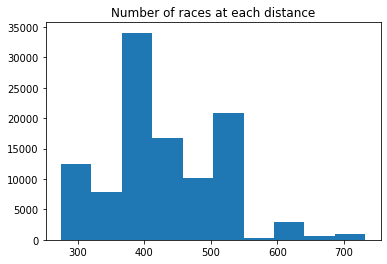

In [4]:
plt.hist(v_features0['Distance'])
plt.title("Number of races at each distance")
plt.show()

### Examine `RaceGrade` feature

Homework: read more on `RaceGrade` to find how to make it useful

In [5]:
v_features0['RaceGrade'].value_counts().head(15)

Grade 5               21606
Maiden                 8932
Mixed 4/5              8818
Grade 6                7675
Grade 5 T3             3986
Grade 5 Heat           3808
Restricted Win         3670
Mixed 6/7              2797
Novice Grade 5         2668
Maiden Heat            2583
Free For All           2546
Novice Non Penalty     2370
Mixed 3/4              1904
Grade 4                1779
Open                   1743
Name: RaceGrade, dtype: int64

## Final dataset

In [6]:
def get_venue_features(data):
    v_features = data[['Distance']]
    v_features.index = v_features.index.droplevel(['FasttrackDogId', 'TrainerId'])
    v_features = v_features.reset_index().drop_duplicates().set_index(['RaceDate', 'FasttrackRaceId'])

    distance_scaler = MinMaxScaler()
    v_features['Distance'] = distance_scaler.fit_transform(v_features[['Distance']])

    return v_features

v_features = get_venue_features(data)
v_features

Distance
RaceDate   FasttrackRaceId          
2018-07-01 335811282        0.492341
           335811293        0.328228
           335811292        0.328228
           335811291        0.328228
           335811288        0.328228
...                              ...
2021-11-30 734778633        0.054705
           734778634        0.059081
           734778635        0.059081
           734778636        0.284464
           734778637        0.470460

[106942 rows x 1 columns]

# Runner Features

## Static Runner Features

In [83]:
sr_features0 = data[['Box', 'Weight']].copy()
sr_features0.index = sr_features0.index.droplevel('TrainerId')

display(sr_features0)

sr_features0 = sr_features0.reset_index().set_index(['RaceDate', 'FasttrackRaceId', 'Box', 'FasttrackDogId']).sort_index().reset_index('Box')
sr_features0['HasInsideNeighbour'] = np.insert(sr_features0.Box[1:].values == sr_features0.Box[:-1].values + 1, 0, 0) * 1
sr_features0['HasOutsideNeighbour'] = np.append(sr_features0.Box[1:].values == sr_features0.Box[:-1].values + 1, 0) * 1

one_hot_encoder = OneHotEncoder()
sr_features0[[f"Box_{i}" for i in range(1, 9)]] = one_hot_encoder.fit_transform(sr_features0[['Box']]).toarray()
sr_features0 = sr_features0.drop(columns = ['Box'])

standard_scaler = StandardScaler()
sr_features0['Weight'] = standard_scaler.fit_transform(sr_features0[['Weight']])
sr_features0

Box  Weight
RaceDate   FasttrackRaceId FasttrackDogId             
2018-07-01 335811282       157500927         1    27.4
                           1820620018        2    32.8
                           1950680026        6    25.5
                           1524380048        7    32.2
                           124225458         4    28.9
...                                        ...     ...
2021-11-30 734778635       614057722         3    25.0
           734778636       576142623         1    29.1
                           540582677         7    26.1
                           580792922         5    25.5
           734778637       504470931         1    32.3

[763167 rows x 2 columns]

Weight  HasInsideNeighbour  \
RaceDate   FasttrackRaceId FasttrackDogId                                 
2018-07-01 334309830       196374475       0.591269                   0   
                           119991023       0.441686                   1   
                           160105572       1.040019                   1   
                           184224214       0.770769                   1   
                           131736468      -1.652480                   1   
...                                             ...                 ...   
2021-11-30 735164905       438202679      -0.545564                   1   
                           536729322      -0.844730                   1   
                           550747962       1.159686                   0   
                           524412240       0.890436                   1   
                           570556341      -0.784897                   0   

                                           HasOutsideNeighbour  Box_1  Box_2  \
RaceDate   FasttrackRaceId FasttrackDogId                                      
2018-07-01 334309830       196374475                         1    1.0    0.0   
                           119991023                         1    0.0    1.0   
                           160105572                         1    0.0    0.0   
                           184224214                         1    0.0    0.0   
                           131736468                         1    0.0    0.0   
...                                                        ...    ...    ...   
2021-11-30 735164905       438202679                         1    0.0    1.0   
                           536729322                         0    0.0    0.0   
                           550747962                         1    0.0    0.0   
                           524412240                         0    0.0    0.0   
                           570556341                         0    0.0    0.0   

                                           Box_3  Box_4  Box_5  Box_6  Box_7  \
RaceDate   FasttrackRaceId FasttrackDogId                                      
2018-07-01 334309830       196374475         0.0    0.0    0.0    0.0    0.0   
                           119991023         0.0    0.0    0.0    0.0    0.0   
                           160105572         1.0    0.0    0.0    0.0    0.0   
                           184224214         0.0    1.0    0.0    0.0    0.0   
                           131736468         0.0    0.0    1.0    0.0    0.0   
...                                          ...    ...    ...    ...    ...   
2021-11-30 735164905       438202679         0.0    0.0    0.0    0.0    0.0   
                           536729322         1.0    0.0    0.0    0.0    0.0   
                           550747962         0.0    0.0    1.0    0.0    0.0   
                           524412240         0.0    0.0    0.0    1.0    0.0   
                           570556341         0.0    0.0    0.0    0.0    0.0   

                                           Box_8  
RaceDate   FasttrackRaceId FasttrackDogId         
2018-07-01 334309830       196374475         0.0  
                           119991023         0.0  
                           160105572         0.0  
                           184224214         0.0  
                           131736468         0.0  
...                                          ...  
2021-11-30 735164905       438202679         0.0  
                           536729322         0.0  
                           550747962         0.0  
                           524412240         0.0  
                           570556341         1.0  

[763167 rows x 11 columns]

### Examine `Weight` feature

Two peaks can be explained by dog's gender.

Bitches are generally lighter than dogs (https://www.greyhoundpredictor.com/prediction/page8.html). Need to collect gender data!

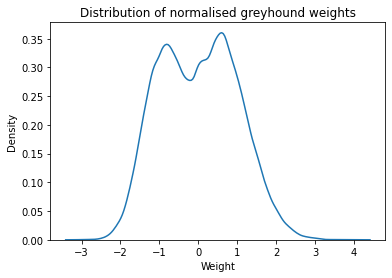

In [78]:
sns.kdeplot(sr_features0['Weight'])
plt.title("Distribution of normalised greyhound weights")
plt.show()

## Inferred Runner Features

In [79]:
data['AverageSpeed'] = data.Distance / data.RunTime

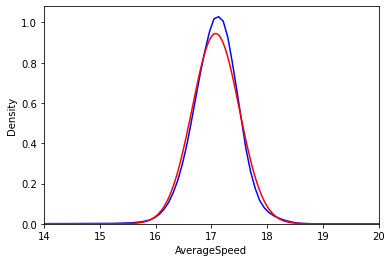

In [80]:

mu = data.AverageSpeed.mean()
sd = data.AverageSpeed.std()
xs = np.linspace(14, 20, 1000)

# shape = (mu / sd) ** 2
# scale = mu / shape


sns.kdeplot(data.AverageSpeed, color = 'blue')
plt.plot(xs, norm.pdf(xs, loc = mu, scale = sd), color = 'red')
# plt.plot(xs, gamma.pdf(xs, a = shape, scale = scale), color = 'green')
plt.xlim((14, 20))
plt.show()

## Final Dataset

# Trainer Features